# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, Mar 07, 5:00pm

**Late Penalty**:  Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Shiva Akbari <shiva.akbari@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/151Y5uYgrftHh4Kwp49bfWmpSWuMFFIj-?usp=sharing

In [71]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [72]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [133]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [134]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [135]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [136]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [137]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [139]:
#we will use describe to find the min, max and avg of the selected columns
subdf.describe().loc[['mean','max','min']]

,age,yredu,capgain,caploss,workhr
mean,38.581647,10.080679,1077.648844,87.30383,40.437456
max,90.000000,16.000000,99999.000000,4356.00000,99.000000
min,17.000000,1.000000,0.000000,0.00000,1.000000


In [140]:
#we use a for loop for normalisation

for column in subdf.columns:
  df[column] = (df[column]-(df[column]).min()) / ((df[column]).max() - (df[column]).min()) #using the formula

df[["age", "yredu", "capgain", "caploss", "workhr"]].describe().loc[['mean','max','min']] #visualise changes

,age,yredu,capgain,caploss,workhr
mean,0.295639,0.605379,0.010777,0.020042,0.402423
max,1.000000,1.000000,1.000000,1.000000,1.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [80]:
# hint: you can do something like this in pandas
percentage_males = sum(df["sex"] == " Male") * 100/len(df)
print(f"Percentage of males is {percentage_males:.2f}%")

percentage_females = sum(df["sex"] == " Female") * 100/len(df)
print(f"Percentage of females is {percentage_females:.2f}%")


Percentage of males is 66.92%
Percentage of females is 33.08%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [81]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [82]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [83]:
print(f"{len(df_with_missing)} records were missing features")
print (f"{len(df_with_missing)/len(df):.2f}% of records were removed")

1843 records were missing features
0.06% of records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [84]:
print(set(df_not_missing["work"]), " are the 'work' features in df_not_missing")


{' Self-emp-not-inc', ' State-gov', ' Local-gov', ' Federal-gov', ' Private', ' Without-pay', ' Self-emp-inc'}  are the 'work' features in df_not_missing


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [85]:
data = pd.get_dummies(df_not_missing)

In [141]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [87]:
print(len(data.columns))

57


`Data` dataframe contains 57 columns. These come from the one-hot encodings of all the possible values of the categorical categories. This allows us to represent whether the person belongs to a specific categorical variable in a binary manner. 57 means that there are a total of 57 categorical descriptors in the dataset. 

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [88]:
datanp = data.values.astype(np.float32)

In [89]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)] 
    #since we have to return the categorical value name with the highest prediction confidence, 
    #we use np.argmax to get the index of that feature to look in cat_values dict

In [90]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [93]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)
total_data = len(datanp)
train_data, val_data, test_data = datanp[:int(0.7*total_data)], datanp[int(0.7*total_data):int(0.85*total_data)], datanp[int(0.85*total_data):]
print(f"Length of training data is {len(train_data)}, length of val data is {len(val_data)}, and length of test data is {len(test_data)}.")

Length of training data is 21502, length of val data is 4608, and length of test data is 4608.


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [95]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        self.name = "AutoEncoder"

        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(57, 28), 
            nn.ReLU(),
            nn.Linear(28,14),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(14,28),
            nn.ReLU(),
            nn.Linear(28,57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The data in the columns for the categorical one-hot encoded values are between 0 and 1 due to the normalization performed earlier, by using sigmoid, we force the output to be between 0 and 1 as well, therefore the output would match the autoencoder input data type. 



## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [96]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [104]:
import os
import matplotlib.pyplot as plt

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_data, val_data, batch_size, num_epochs=5, learning_rate=1e-4, plot = True):
    """ Training loop. You should update this."""
    
    train_loader= torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
    val_loader= torch.utils.data.DataLoader(val_data, batch_size= batch_size, shuffle = True)
    model = model.to(device)
    torch.manual_seed(42)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose= True, min_lr=1e-6)

    iters, losses, val_losses, acc, val_acc = [], [], [], [], []
    model_path = f"model_{model.name}_bs{batch_size}_lr{learning_rate}_epochs{num_epochs}"
    os.makedirs(os.path.join("/content/backup",model_path), exist_ok = True)
    model.train()        
    for epoch in range(num_epochs):
        train_loss_per_epoch, train_batches, val_loss_per_epoch, val_batches = 0.0, 0.0, 0.0, 0.0
        for data in train_loader:
            data = data.to(device)
            datam = zero_out_random_feature(data.clone()).to(device) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            train_loss_per_epoch += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_batches +=1

        for data_val in val_loader:
            data_val = data_val.to(device)
            datam_val = zero_out_random_feature(data_val.clone()).to(device) # zero out one categorical feature
            recon_val = model(datam_val)
            val_loss = criterion(recon_val, data_val)
            val_loss_per_epoch += val_loss.item()
            val_batches +=1

        iters.append(epoch)
        losses.append(float(train_loss_per_epoch)/train_batches) # compute training loss
        acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        val_losses.append(float(val_loss_per_epoch)/val_batches) # compute val loss
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        scheduler.step(val_acc[-1])

        print(f"Epoch {epoch + 1}/{num_epochs}: Training loss {losses[-1]:.3f} , Val loss {val_losses[-1]:.3f} , Training accuracy {acc[-1]:.3f} , Val accuracy {val_acc[-1]:.3f}")
        if val_acc[-1]==max(val_acc):
            torch.save(model.state_dict(), os.path.join("/content/backup", model_path, "best.pth"))
            print ("best model saved")
        if epoch % 10 == 0:
            torch.save(model.state_dict(), os.path.join("/content/backup", model_path, f"{epoch}.pth"))
            print ("checkpoint model saved")

    print (f"Best training accuracy is {max(acc)}")
    print (f"Best val accuracy is {max(val_acc)}")
    if plot: # plotting
      plt.title("Loss Curve")
      plt.plot(iters, losses, label="Train")
      plt.plot(iters, val_losses, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.legend(loc='best')
      plt.show()

      plt.title("Accuracy Curve")
      plt.plot(iters, acc, label="Train")
      plt.plot(iters, val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()       

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [98]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    model.eval()
    total = 0
    acc = 0
    model = model.to("cpu")
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    model = model.to(device)
    model.train()
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1/50: Training loss 0.072 , Val loss 0.047 , Training accuracy 0.577 , Val accuracy 0.578
best model saved
checkpoint model saved
Epoch 2/50: Training loss 0.038 , Val loss 0.034 , Training accuracy 0.601 , Val accuracy 0.599
best model saved
Epoch 3/50: Training loss 0.031 , Val loss 0.029 , Training accuracy 0.604 , Val accuracy 0.602
best model saved
Epoch 4/50: Training loss 0.027 , Val loss 0.027 , Training accuracy 0.597 , Val accuracy 0.599
Epoch     5: reducing learning rate of group 0 to 5.0000e-04.
Epoch 5/50: Training loss 0.025 , Val loss 0.024 , Training accuracy 0.598 , Val accuracy 0.601
Epoch 6/50: Training loss 0.023 , Val loss 0.023 , Training accuracy 0.595 , Val accuracy 0.594
Epoch 7/50: Training loss 0.022 , Val loss 0.022 , Training accuracy 0.609 , Val accuracy 0.609
best model saved
Epoch 8/50: Training loss 0.021 , Val loss 0.021 , Training accuracy 0.603 , Val accuracy 0.601
Epoch     9: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9/50: Train

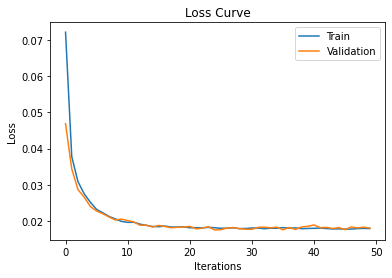

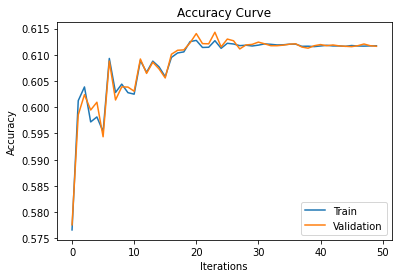

In [99]:
model = AutoEncoder()
batch_size = 32
num_epochs = 50
learning_rate = 0.001

train(model, train_data, val_data, batch_size, num_epochs=num_epochs, learning_rate=learning_rate, plot = True)

In [66]:
!rm -r /content/backup

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

The main hyperparameter training is related to learning rate and batch size. We can try learning rate to be 0.001 and 0.005, with batch size being 32 and 64. number of epochs is set at 50, as shown above that 50 epochs are enough for model to stabilise.

The reason for trying a batch size of 64 and learning rate of 0.005 is to accelerate training, but keep it more generalised training (though the training accuracy and validation acc follow closely, implying that the generalization ability of the model is great)

In [105]:
model = AutoEncoder()
batch_size = 64
num_epochs = 50
learning_rate = 0.001

train(model, train_data, val_data, batch_size, num_epochs=num_epochs, learning_rate=learning_rate, plot = False)

Epoch 1/50: Training loss 0.092 , Val loss 0.055 , Training accuracy 0.536 , Val accuracy 0.539
best model saved
checkpoint model saved
Epoch 2/50: Training loss 0.048 , Val loss 0.041 , Training accuracy 0.586 , Val accuracy 0.587
best model saved
Epoch 3/50: Training loss 0.038 , Val loss 0.035 , Training accuracy 0.611 , Val accuracy 0.607
best model saved
Epoch 4/50: Training loss 0.032 , Val loss 0.031 , Training accuracy 0.606 , Val accuracy 0.602
Epoch     5: reducing learning rate of group 0 to 5.0000e-04.
Epoch 5/50: Training loss 0.031 , Val loss 0.030 , Training accuracy 0.613 , Val accuracy 0.612
best model saved
Epoch 6/50: Training loss 0.029 , Val loss 0.029 , Training accuracy 0.612 , Val accuracy 0.611
Epoch 7/50: Training loss 0.028 , Val loss 0.027 , Training accuracy 0.612 , Val accuracy 0.611
Epoch 8/50: Training loss 0.026 , Val loss 0.026 , Training accuracy 0.609 , Val accuracy 0.609
Epoch     9: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9/50: Train

In [106]:
model = AutoEncoder()
batch_size = 32
num_epochs = 50
learning_rate = 0.005

train(model, train_data, val_data, batch_size, num_epochs=num_epochs, learning_rate=learning_rate, plot = False)

Epoch 1/50: Training loss 0.049 , Val loss 0.027 , Training accuracy 0.599 , Val accuracy 0.601
best model saved
checkpoint model saved
Epoch 2/50: Training loss 0.025 , Val loss 0.023 , Training accuracy 0.576 , Val accuracy 0.578
Epoch 3/50: Training loss 0.021 , Val loss 0.021 , Training accuracy 0.592 , Val accuracy 0.590
Epoch 4/50: Training loss 0.020 , Val loss 0.019 , Training accuracy 0.606 , Val accuracy 0.605
best model saved
Epoch 5/50: Training loss 0.019 , Val loss 0.018 , Training accuracy 0.610 , Val accuracy 0.607
best model saved
Epoch     6: reducing learning rate of group 0 to 2.5000e-03.
Epoch 6/50: Training loss 0.017 , Val loss 0.017 , Training accuracy 0.606 , Val accuracy 0.607
Epoch 7/50: Training loss 0.016 , Val loss 0.016 , Training accuracy 0.623 , Val accuracy 0.622
best model saved
Epoch 8/50: Training loss 0.015 , Val loss 0.016 , Training accuracy 0.619 , Val accuracy 0.621
Epoch 9/50: Training loss 0.015 , Val loss 0.015 , Training accuracy 0.615 , Va

In [107]:
model = AutoEncoder()
batch_size = 64
num_epochs = 50
learning_rate = 0.005

train(model, train_data, val_data, batch_size, num_epochs=num_epochs, learning_rate=learning_rate, plot = False)

Epoch 1/50: Training loss 0.063 , Val loss 0.040 , Training accuracy 0.595 , Val accuracy 0.598
best model saved
checkpoint model saved
Epoch 2/50: Training loss 0.032 , Val loss 0.027 , Training accuracy 0.581 , Val accuracy 0.583
Epoch 3/50: Training loss 0.026 , Val loss 0.024 , Training accuracy 0.593 , Val accuracy 0.595
Epoch 4/50: Training loss 0.023 , Val loss 0.022 , Training accuracy 0.593 , Val accuracy 0.594
Epoch 5/50: Training loss 0.022 , Val loss 0.021 , Training accuracy 0.597 , Val accuracy 0.599
best model saved
Epoch     6: reducing learning rate of group 0 to 2.5000e-03.
Epoch 6/50: Training loss 0.021 , Val loss 0.021 , Training accuracy 0.595 , Val accuracy 0.598
Epoch 7/50: Training loss 0.020 , Val loss 0.019 , Training accuracy 0.611 , Val accuracy 0.613
best model saved
Epoch 8/50: Training loss 0.019 , Val loss 0.019 , Training accuracy 0.612 , Val accuracy 0.614
best model saved
Epoch 9/50: Training loss 0.019 , Val loss 0.018 , Training accuracy 0.613 , Va

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

Given that the best performance is achieved with batch size of 32 and learning rate of 0.005, we use the best model from there.

In [109]:
model = AutoEncoder()
model.load_state_dict(torch.load("/content/backup/model_AutoEncoder_bs32_lr0.005_epochs50/best.pth"))

test_loader= torch.utils.data.DataLoader(test_data, batch_size= 1, shuffle= True)

test_acc= get_accuracy(model, test_loader)

print(f'The test accuracy is {(test_acc * 100):.2f}%')

The test accuracy is 67.19%


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [142]:
mode = {}
accuracy = 0.0

for col in df_not_missing.columns:
  mode[col] = df_not_missing[col].mode()[0] # get the most common value for each column
  accuracy_col = sum(df_not_missing[col] == mode[col])/len(df_not_missing)
  print (f"Accuracy for category {col} is {accuracy_col*100:.2f}%")
  accuracy += accuracy_col
print(f"The accuracy for baseline model is {accuracy*100/len(df_not_missing.columns):.2f}%")

Accuracy for category age is 2.85%
Accuracy for category yredu is 32.45%
Accuracy for category capgain is 91.57%
Accuracy for category caploss is 95.24%
Accuracy for category workhr is 47.28%
Accuracy for category work is 73.89%
Accuracy for category marriage is 46.68%
Accuracy for category occupation is 13.48%
Accuracy for category edu is 32.45%
Accuracy for category relationship is 41.36%
Accuracy for category sex is 67.67%
The accuracy for baseline model is 49.54%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The accuracy in part(a) is much better than part(b). This could be because our Neural Net learns to predict based on the features presented, whereas the baseline just uses the mode of the column. However, it could be that our dataset is skewed towards certain values and the autoencoder is predicting only for some categories but not for others as some columns do see a high accuracy by using the mode value.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [125]:
get_features(test_data[0])

{'edu': '11th',
 'marriage': 'Divorced',
 'occupation': 'Other-service',
 'relationship': 'Unmarried',
 'sex': 'Female',
 'work': 'Private'}

A human may not be able to guess this person's education level, as this is a very generic profile that does not disclose much. A common guess for edu would be high school or bachelor's, but not 11th. 

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [143]:
#the model is already loaded from testing.
single_test_data = test_data[0]
single_test_data[cat_index['edu']:cat_index['edu'] + len(cat_values['edu'])] = 0
single_test_data = torch.from_numpy(single_test_data).to(device)  
pred = model(single_test_data)
pred = pred.detach().cpu().numpy()
pred_edu = get_feature(pred, "edu")
print(pred_edu)

HS-grad


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [144]:
print(mode['edu'])

 HS-grad
